## Custom scaler methods: DerivativeRank and logscaler

two custom scaler methods are defined and tested

#### DerivativeRank
allows to set a suitable tradeoff between fixing the distribution of a feature and preserving information from original data.
It is basically a discrete derivative of rank scaling (e.g. like [pandas rank](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html) or similar to sklearn [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer)). compared to those it preserves more of the information from original data. while rank or quantile transformer produce uniform distribution (or close to uniform in case of repeated values), DerivativeRank produces a distribution which is somewhere between uniform and original. The parameter $d$, the order of derivative, controls how close the resulting distribution is to the original versus the uniform distribution. 

Implementation as recursive funtion:
1. array of values is ordered and consecutive deltas taken, repeated recursively $d$ times
2. differences are set to constant value $1$
3. integrating back $d$ times, each time inversing the permutation of ordering applied in delta calculation, to obtain scaled array of values


#### logscaler
an extension of logarithm to whole real numbers for feature scaling purpose. log-scaler has one parameter to control the behaviour around zero

### this notebook
1. defines and plots an extension of logarithm to whole real numbers

2. imports and demos the DerivativeRank on two example datasets and observe the correlation


In [1]:
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.preprocessing import QuantileTransformer
from scipy.spatial.distance import pdist


# import own derivative rank scaler
from derivative_rank import DerivativeRankScaler

#### Logscaler to extend log scaling on whole real numbers
is it not possible to continuously combine the functions $\log(x)$ and $-\log(-x)$. to obtain at least a monotone function, between $-1$ and $1$ a bridge is added, and it can be extended to allow a smoother transition: bridge parameter close to one gives a sharp transition. close to 0 it gives a smoother alignment to the log function and will differ from log function on a wider interval around zero


In [2]:
def logscaler(X, bridge_param=0.3):
    """ scale log-like, extended on all real numbers
    
    X: array of real numbers to scale
    bridge_param: from (0,1) determines shape around zero, 
    the closer to 1 the smaller the interval around 0 where the logscaler differs from log
    """
    assert (0 < bridge_param) and (bridge_param < 1), "0 < bridge_param < 1 must be fulfilled"
    return np.sign(X)*np.log(np.abs(X)+np.maximum(1-bridge_param*np.abs(X),0))

#### plotting logscaler with different bridge parameters
- 0.1 as bridge parameter: transition between positive and negative part is rather smooth (visually) and only at large x values above $10$ is the logscaler equal to logarithm
- 0.9 on the other side achieves a quick equality with logarithm, and has abrupt angles
- 0.5 is a cpmpromise between the two

In [3]:
X = np.linspace(-10,10,200)
px.line(pd.DataFrame({"x": np.tile(X,4), "y": np.hstack((logscaler(X,bridge_param=0.1),
                                                           logscaler(X,bridge_param=0.5),
                                                            logscaler(X,bridge_param=0.9),
                                                        np.sign(X)*np.log(np.abs(X)))),
                                                  "info": np.hstack((np.repeat("bridge_param=0.1",200),
                                                                     np.repeat("bridge_param=0.5",200),
                                                                     np.repeat("bridge_param=0.9",200),
                                                                    np.repeat("mirrored log",200))),}).iloc[::-1],
                                                           x="x", y="y", 
                                                           color="info")

### Derivative Rank Scaler
#### example distribution 1
increasing the order of derivative is weakening the effect of scaling, i.e. distribution gets closed to original

array([<AxesSubplot:title={'center':'Quantile Tr'}>], dtype=object)

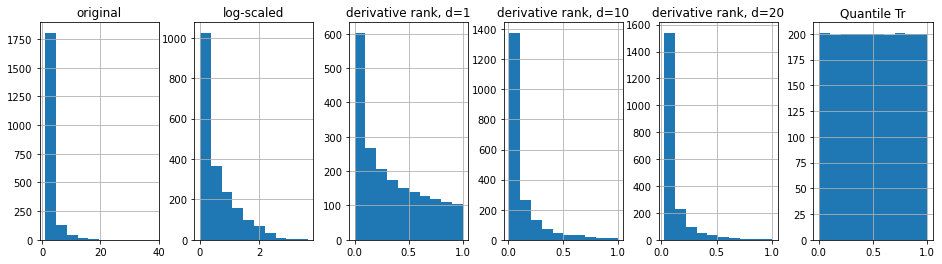

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize= (16,4))  
k = 2000
example_1 = np.exp( sorted(np.abs(np.random.randn(k))) *np.arange(k)/k)
pd.DataFrame({"original": example_1}).hist(ax=axes[0])

log_ex_1 = np.log(example_1)
pd.DataFrame({"log-scaled": log_ex_1}).hist(ax=axes[1])

drs = DerivativeRankScaler(d=1)
drscaled_ex_1 = drs.fit_transform(example_1)
pd.DataFrame({"derivative rank, d=1": drscaled_ex_1}).hist(ax=axes[2])

drs = DerivativeRankScaler(d=10)
drscaled_ex_1 = drs.fit_transform(example_1)
pd.DataFrame({"derivative rank, d=10": drscaled_ex_1}).hist(ax=axes[3])

drs = DerivativeRankScaler(d=20)
drscaled_ex_1 = drs.fit_transform(example_1)
pd.DataFrame({"derivative rank, d=20": drscaled_ex_1}).hist(ax=axes[4])

qnTr = QuantileTransformer()
pd.DataFrame({"Quantile Tr": qnTr.fit_transform(example_1[:,np.newaxis]).flatten()}).hist(ax=axes[5])


#### example distribution 2
increasing the order of derivative is weakening the effect of scaling, i.e. distribution gets closed to original

array([<AxesSubplot:title={'center':'Quantile Transform'}>], dtype=object)

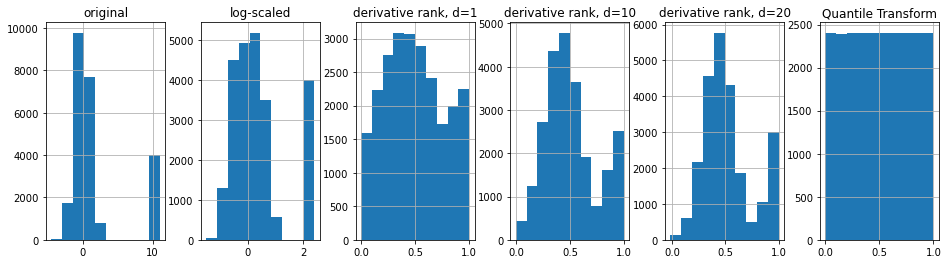

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize= (16,4))  
example_2 = (np.concatenate((np.random.randn(20000),(np.random.rand(4000)+10))) )
pd.DataFrame({"original": example_2}).hist(ax=axes[0])

log_ex_2 = logscaler(example_2)
pd.DataFrame({"log-scaled": log_ex_2}).hist(ax=axes[1])

drs = DerivativeRankScaler(d=1)
drscaled_ex_2 = drs.fit_transform(example_2)
pd.DataFrame({"derivative rank, d=1": drscaled_ex_2}).hist(ax=axes[2])

drs = DerivativeRankScaler(d=10)
drscaled_ex_2 = drs.fit_transform(example_2)
pd.DataFrame({"derivative rank, d=10": drscaled_ex_2}).hist(ax=axes[3])

d = 20
drs = DerivativeRankScaler(d=d)
drscaled_ex_2 = drs.fit_transform(example_2)
pd.DataFrame({"derivative rank, d={0}".format(d): drscaled_ex_2}).hist(ax=axes[4])

qnTr = QuantileTransformer()
pd.DataFrame({"Quantile Transform": qnTr.fit_transform(example_2[:,np.newaxis]).flatten()}).hist(ax=axes[5])


#### example distribution 3
increasing the order of derivative is weakening the effect of scaling, i.e. distribution gets closed to original

array([<AxesSubplot:title={'center':'Quantile Tr'}>], dtype=object)

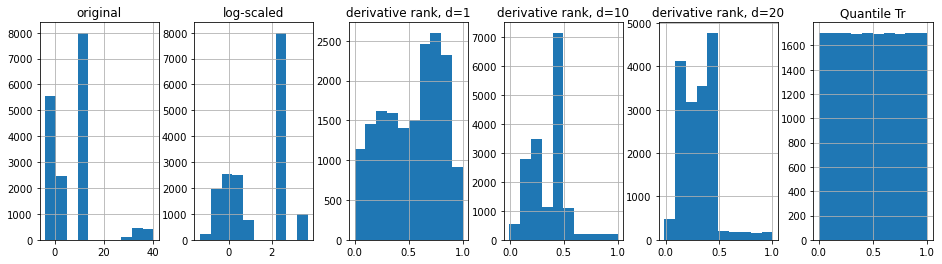

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize= (16,4))  
example_3 = (np.concatenate((np.random.randn(8000),(np.random.rand(8000)+10), (10*np.random.rand(1000)+30))) )
pd.DataFrame({"original": example_3}).hist(ax=axes[0])


log_ex_3 = logscaler(example_3)
pd.DataFrame({"log-scaled": log_ex_3}).hist(ax=axes[1])

drs = DerivativeRankScaler(d=1)
drscaled_ex_3 = drs.fit_transform(example_3)
pd.DataFrame({"derivative rank, d=1": drscaled_ex_3}).hist(ax=axes[2])

drs = DerivativeRankScaler(d=10)
drscaled_ex_3 = drs.fit_transform(example_3)
pd.DataFrame({"derivative rank, d=10": drscaled_ex_3}).hist(ax=axes[3])

drs = DerivativeRankScaler(d=20)
drscaled_ex_3 = drs.fit_transform(example_3)
pd.DataFrame({"derivative rank, d=20": drscaled_ex_3}).hist(ax=axes[4])

qnTr = QuantileTransformer()
pd.DataFrame({"Quantile Tr": qnTr.fit_transform(example_3[:,np.newaxis]).flatten()}).hist(ax=axes[5])


#### compare how much the pairwise differences of points are correlated between scaled and original data 
as a measure of how much of the information from the original distribution is preserved the correlation of pairwise differences between values is used.  
this value is compared for derivative scaled distribution, the log-scaled distribution and the rank-scaled distribution



In [10]:
# select the example (from above) on which to calculate the measure
example = example_1

n = example.shape[0]
# calculate only on a sample of points (since num of all pairs can get too large)
sample = np.random.choice(np.arange(n),size=1000,replace=False).astype(int)

drs = DerivativeRankScaler(d=1)
drscaled_1_dist_corr = np.corrcoef(np.stack((pdist(example[sample,np.newaxis]),
             pdist(drs.fit_transform(example)[sample,np.newaxis])), axis=0))[0,1]

drs = DerivativeRankScaler(d=10)
drscaled_10_dist_corr = np.corrcoef(np.stack((pdist(example[sample,np.newaxis]),
             pdist(drs.fit_transform(example)[sample,np.newaxis])), axis=0))[0,1]


logscaled_dist_corr =  np.corrcoef(np.stack((pdist(example[sample,np.newaxis]),
             pdist(logscaler(example)[sample,np.newaxis])), axis=0))[0,1]

qnTr = QuantileTransformer()
quantile_dist_corr = np.corrcoef(np.stack((pdist(example[sample,np.newaxis]),
             pdist(qnTr.fit_transform(example[sample,np.newaxis]))), axis=0))[0,1]


print("derivative rank (d=1) scaled", drscaled_1_dist_corr)
print("derivative rank (d=10) scaled", drscaled_10_dist_corr)
print("log-scaler", logscaled_dist_corr)
print("QuantileTransformer", quantile_dist_corr)

derivative rank (d=1) scaled 0.5773692747684686
derivative rank (d=10) scaled 0.8900006903867509
log-scaler 0.902846407714289
QuantileTransformer 0.3967337511246382
